In [3]:
# -- packages for the code --
import time
import gymnasium as gym
import mo_gymnasium as mo_gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# -- packages for the baselines --
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
import random

# -- packages for the graphs --
import pandas as pd   
import seaborn as sns 
import scikit_posthocs as sp

Definition of the environment with a modification to reach the goal

In [4]:
class MountainCar_bonus(gym.Env):
    def __init__(self, success_bonus=200.0):
        super().__init__()
        self.env = mo_gym.make("mo-mountaincar-v0")
        self.observation_space = self.env.observation_space
        self.action_space    = self.env.action_space
        self.success_bonus   = success_bonus

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        return obs, info

    def step(self, action):
        obs, reward_vec, terminated, truncated, info = self.env.step(action)
        bonus = self.success_bonus if info.get("is_success", False) else 0.0
        shaped = reward_vec.copy()
        shaped[0] += bonus
        return obs, shaped, terminated, truncated, info

Pareto Tracer - PPO implementation in Multi-objective Car mountain environment

------------------------------------------------------------------
| time/                   |              |
|    fps                  |         2392 |
|    iterations           |           20 |
|    time_elapsed         |           17 |
|    total_timesteps      |        40960 |
| train/                  |              |
|    approx_kl            |    0.0002072 |
|    clip_fraction        |      0.00000 |
|    clip_range           |          0.2 |
|    entropy_loss         |      -1.0635 |
|    explained_variance   |     -0.00019 |
|    learning_rate        |    0.0001000 |
|    loss                 |    109.64224 |
|    n_updates            |          100 |
|    policy_gradient_loss |     14.00795 |
|    value_loss           |     95.63429 |
------------------------------------------------------------------
------------------------------------------------------------------
| time/                   |              |
|    fps                  |         2336 |
|    iterations          

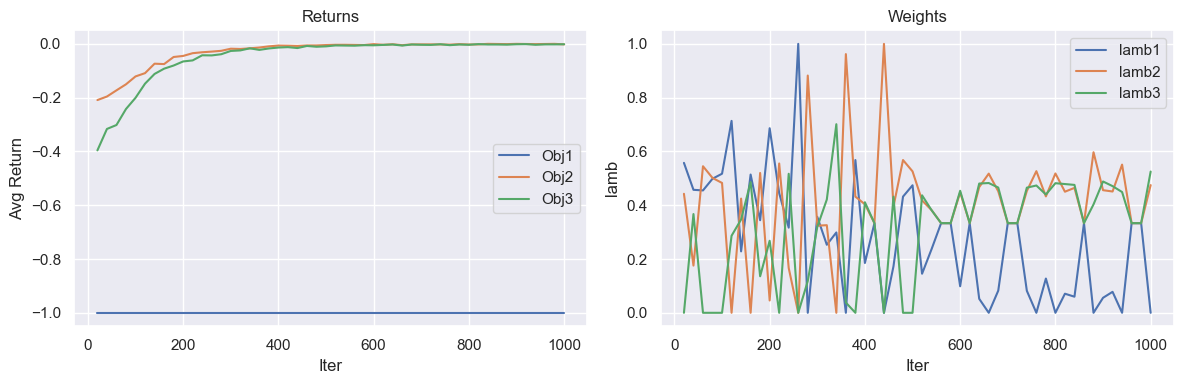

In [7]:
# 1. Environment 
env = MountainCar_bonus()
obs, _ = env.reset()
a = env.action_space.sample()
obs, reward_vec, term, trunc, _ = env.step(a)
k = reward_vec.shape[0]
env.reset()

# 2. Models
class Actor(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 64), nn.ReLU(),
            nn.Linear(64, act_dim)
        )
    def forward(self, x): return self.net(x)

class Critic(nn.Module):
    def __init__(self, obs_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x): return self.net(x)

# 3. Definition of the main functions
def collect_rollout(env, policy, batch_size):
    S,A,LP,R,D,NS = [],[],[],[],[],[]
    obs,_ = env.reset()
    for _ in range(batch_size):
        S.append(obs.copy())
        logits = policy(torch.tensor(obs, dtype=torch.float32).unsqueeze(0))
        dist = Categorical(logits=logits)
        a = dist.sample().item()
        lp = dist.log_prob(torch.tensor(a)).item()
        obs, rv, t, tr, _ = env.step(a)
        done = t or tr
        A.append(a); LP.append(lp); R.append(rv); D.append(done); NS.append(obs.copy())
        if done: obs,_ = env.reset()
    return {
        'states': torch.tensor(S, dtype=torch.float32),
        'actions': torch.tensor(A),
        'old_logps': torch.tensor(LP, dtype=torch.float32),
        'rewards': torch.tensor(R, dtype=torch.float32),
        'dones': torch.tensor(D, dtype=torch.float32),
        'next_states': torch.tensor(NS, dtype=torch.float32),
    }

def GAE(rewards, states, next_states, dones, critic, gamma, lamb):
    vals = critic(states).squeeze(-1).detach().numpy()
    nvals = critic(next_states).squeeze(-1).detach().numpy()
    rews, dns = rewards.numpy(), dones.numpy()
    adv = np.zeros_like(rews); last=0

    for t in reversed(range(len(rews))):
        mask = 1-dns[t]
        delta = rews[t] + gamma*nvals[t]*mask - vals[t]
        last = delta + gamma*lamb*mask*last
        adv[t] = last

    return torch.tensor(adv, dtype=torch.float32), torch.tensor(adv+vals, dtype=torch.float32)

def ppo_loss(policy, S, A, LP, advs, epsilon):
    logits = policy(S)
    dist = Categorical(logits=logits)
    r = torch.exp(dist.log_prob(A)-LP)
    s1, s2 = r*advs, torch.clamp(r,1-epsilon,1+epsilon)*advs
    return -torch.mean(torch.min(s1,s2))

def lambda_solver(grads):
    G = np.vstack(grads)
    def obj(l): return np.linalg.norm(l.dot(G))**2
    cons = ({'type':'eq','fun': lambda l: l.sum()-1},
            {'type':'ineq','fun': lambda l: l})
    x0 = np.ones(len(grads))/len(grads)
    return minimize(obj,x0,constraints=cons).x

def direction(grads):
    G = np.vstack(grads)
    _,_,Vh = np.linalg.svd(G, full_matrices=True)
    v = Vh[k]  
    return torch.tensor(v/np.linalg.norm(v), dtype=torch.float32)


def variance(y, y_pred):
    var_y = np.var(y)
    return 1 - np.var(y - y_pred) / (var_y + 1e-8)

# 4. Training & logging function
def train_and_log(env, policy, critics, opt,
                          iters=1000, batch=2048,
                          gamma=0.99, lamb=0.90, epsilon=0.2,
                          alpha=1e-2, ppo_epochs=5, log_int=20):

    k = len(critics)
    logs = {
        'its':   [],
        'objs':  [[] for _ in range(k)],  
        'lams':  []
    }
    total_steps = 0
    update_count = 0
    start_time = time.time()

    for it in range(1, iters + 1):
        
        D = collect_rollout(env, policy, batch)
        total_steps += batch

        advs, rets = [], []
        for i in range(k):
            a, r = GAE(
                D['rewards'][:, i], D['states'], D['next_states'],
                D['dones'], critics[i], gamma, lamb
            )
            advs.append(a); rets.append(r)

        grads = []
        for i in range(k):
            loss_i = ppo_loss(
                policy, D['states'], D['actions'],
                D['old_logps'], advs[i], epsilon
            )
            opt.zero_grad()
            loss_i.backward(retain_graph=True)
            grads.append(parameters_to_vector([p.grad for p in policy.parameters()]).cpu().numpy())

        # Corrector - Predictor actualization step
        lams = lambda_solver(grads)
        v = direction(grads)
        theta = parameters_to_vector(policy.parameters())
        theta += alpha * v
        vector_to_parameters(theta, policy.parameters())

        # PPO actor update
        actor_loss_val = 0.0
        clip_fraction_val = 0.0
        entropy_val = 0.0
        for _ in range(ppo_epochs):
            logits = policy(D['states'])
            dist = Categorical(logits=logits)
            new_logps = dist.log_prob(D['actions'])
            ratio = torch.exp(new_logps - D['old_logps'])
            clip_fraction_val += ((ratio > 1+epsilon) | (ratio < 1-epsilon)).float().mean().item()
            entropy_val += dist.entropy().mean().item()

            al = sum(ppo_loss(policy, D['states'], D['actions'],
                                        D['old_logps'], advs[i], epsilon)
                     for i in range(k))
            opt.zero_grad()
            al.backward()
            opt.step()
            actor_loss_val += al.item()
            update_count += 1

        clip_fraction_val /= ppo_epochs
        entropy_val = -entropy_val / ppo_epochs
        actor_loss_val /= ppo_epochs

        # Critic update
        value_loss_val = 0.0
        ev_val = 0.0
        for i in range(k):
            pred = critics[i](D['states']).squeeze(-1)
            cl = F.mse_loss(pred, rets[i])
            opt.zero_grad()
            cl.backward()
            opt.step()
            value_loss_val += cl.item()

            
            ev_val += variance(rets[i].detach().cpu().numpy(),
                                         pred.detach().cpu().numpy())
        ev_val /= k

        # Logging
        if it % log_int == 0:
            logs['its'].append(it)
            avg_returns = D['rewards'].mean(dim=0).tolist()
            for i in range(k):
                logs['objs'][i].append(avg_returns[i])
            logs['lams'].append(lams)

            elapsed = time.time() - start_time
            fps = total_steps / elapsed
            total_timesteps = total_steps
            iterations = it

            
            approx_kl = (D['old_logps'] - new_logps).mean().item()
            lr = opt.param_groups[0]['lr']
            clip_range = epsilon
            loss_val = actor_loss_val + value_loss_val

            # SB3-style
            print("-" * 66)
            print(f"| time/                   |              |")
            print(f"|    fps                  | {fps:12.0f} |")
            print(f"|    iterations           | {iterations:12d} |")
            print(f"|    time_elapsed         | {elapsed:12.0f} |")
            print(f"|    total_timesteps      | {total_timesteps:12d} |")
            print(f"| train/                  |              |")
            print(f"|    approx_kl            | {approx_kl:12.7f} |")
            print(f"|    clip_fraction        | {clip_fraction_val:12.5f} |")
            print(f"|    clip_range           | {clip_range:12.1f} |")
            print(f"|    entropy_loss         | {entropy_val:12.4f} |")
            print(f"|    explained_variance   | {ev_val:12.5f} |")
            print(f"|    learning_rate        | {lr:12.7f} |")
            print(f"|    loss                 | {loss_val:12.5f} |")
            print(f"|    n_updates            | {update_count:12d} |")
            print(f"|    policy_gradient_loss | {actor_loss_val:12.5f} |")
            print(f"|    value_loss           | {value_loss_val:12.5f} |")
            print("-" * 66)

    return logs

# 5. Main

if __name__ == "__main__":
    env = MountainCar_bonus()
    obs_dim = env.observation_space.shape[0]
    policy = Actor(obs_dim, env.action_space.n)
    critics = [Critic(obs_dim) for _ in range(policy.net[-1].out_features)]
    optimizer = torch.optim.Adam(
        list(policy.parameters()) +
        [p for c in critics for p in c.parameters()], lr=1e-4
    )
    start = time.time()
    logs = train_and_log(env, policy, critics, optimizer)
    elapsed = time.time() - start

    # Evaluate policy
    eval_eps = 200
    returns = []
    for ep in range(eval_eps):
        obs,_ = env.reset()
        done=False
        total = np.zeros(k)
        while not done:
            a = torch.argmax(policy(torch.tensor(obs, dtype=torch.float32).unsqueeze(0))).item()
            obs, rv, t, tr, _ = env.step(a)
            done = t or tr
            total += rv
        returns.append(total)
    returns = np.array(returns)
    avg_all = returns.mean(axis=0)
    avg_last100 = returns[-100:].mean(axis=0)
    
    final_lams = logs['lams'][-1]
    
    # Print of all the important output-info
    print("\n=== Final Metrics ===")
    print("Avg episode return over all eval eps:", np.round(avg_all,2))
    print("Avg episode return over last 100 eps:", np.round(avg_last100,2))
    print(f"Training time (s): {elapsed:.2f}")
    print("Final lambda-weights:", np.round(final_lams,2))

    
    print("\n=== Policy State Dict ===")
    for name, param in policy.state_dict().items():
        print(name, param.detach().cpu().numpy(), "\n")

    # 6. Plots
    its = logs['its']
    objs = logs['objs']
    lams = np.array(logs['lams'])
    fig, axs = plt.subplots(1,2,figsize=(12,4))
    for i in range(k):
        axs[0].plot(its, objs[i], label=f'Obj{i+1}')
    axs[0].set(title='Returns', xlabel='Iter', ylabel='Avg Return')
    axs[0].legend(); axs[0].grid(True)

    for i in range(k):
        axs[1].plot(its, lams[:,i], label=f'lamb{i+1}')
    axs[1].set(title='Weights', xlabel='Iter', ylabel='lamb')
    axs[1].legend(); axs[1].grid(True)
    sns.set(style="darkgrid")
    plt.tight_layout(); plt.show()
    

   

    

In [6]:
# scalarized_mo_mountaincar_baseline.py
# -----------------------------------------------------------------------------
# PPO baseline with linear scalarization on mo-mountaincar-v0
# Prerequisites:
#   pip install gymnasium mo-gymnasium stable-baselines3
# -----------------------------------------------------------------------------

import gymnasium as gym
import mo_gymnasium as mo_gym
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

# 1) Wrapper to scalarize multi-objective rewards
class ScalarizeReward(gym.Wrapper):
    def __init__(self, env, weights):
        super().__init__(env)
        self.weights = np.array(weights, dtype=np.float32)
        assert self.weights.ndim == 1
        
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        return obs, info
    
    def step(self, action):
        # env.step returns obs, reward_vector, terminated, truncated, info
        obs, rew_vec, terminated, truncated, info = self.env.step(action)
        # scalarize
        rew = float(self.weights.dot(rew_vec))
        return obs, rew, terminated, truncated, info

# 2) Create a scalarized vectorized environment
def make_env(weights):
    def _init():
        raw = mo_gym.make("mo-mountaincar-v0")
        return ScalarizeReward(raw, weights)
    return _init

# 3) Infer number of objectives to set equal weights
raw_env = mo_gym.make("mo-mountaincar-v0")
obs, _ = raw_env.reset()
_, reward_vec, _, _, _ = raw_env.step(raw_env.action_space.sample())
k = reward_vec.shape[0]
raw_env.close()

# Equal weights baseline
weights = np.ones(k) / k

# 4) Wrap into DummyVecEnv for SB3
vec_env = DummyVecEnv([make_env(weights)])

# 5) Instantiate and train PPO
model = PPO(
    "MlpPolicy",
    vec_env,
    verbose=1,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    clip_range=0.2,
)

total_timesteps = 2_048_000 
model.learn(total_timesteps=total_timesteps)

# 6) Evaluate performance
mean_reward, std_reward = evaluate_policy(
    model,
    vec_env,
    n_eval_episodes=20,
    deterministic=True
)
print(f"\nScalarized PPO (weights={weights})")
print(f"Mean scalarized return over 20 episodes: {mean_reward:.2f} ± {std_reward:.2f}")

# 7) Run one episode to display return
env = ScalarizeReward(mo_gym.make("mo-mountaincar-v0"), weights)
obs, _ = env.reset()
done = False
total = 0.0
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, rew, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    total += rew
print(f"One episode scalarized return: {total:.2f}")


C:\Users\ST\AppData\Roaming\Python\Python311\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 2072 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1457        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012703486 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.00199     |
|    learning_rate        | 0.0003      |
|    loss                 | 1.78        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0138     |
|    value_loss           | 30.5        |
-----------------------------------------
-----------------

C:\Users\ST\AppData\Roaming\Python\Python311\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



Scalarized PPO (weights=[0.33333333 0.33333333 0.33333333])
Mean scalarized return over 20 episodes: -66.67 ± 0.00
One episode scalarized return: -66.67
